# Ноготочки Москва  

## Цель исследования  
Анализ демографических характеристик подписчиков сообществ ВК, посвящённых маникюрным салонам и мастерам в Москве, с целью выявления целевой аудитории для потенциального запуска рекламы.  

## Задачи  
1. **Анализ гендерного состава подписчиков** – определить, насколько значительную долю составляют мужчины и есть ли среди них потенциальный спрос на услуги маникюра.  
2. **Возрастной анализ мужчин** – построить гистограмму возрастного распределения среди подписчиков-мужчин.  
3. **Возрастной анализ женщин** – построить гистограмму возрастного распределения среди подписчиц-женщин.  
4. **Географический анализ** – определить долю подписчиков из Москвы и других городов (по доступным данным).  
5. **Выборка целевой аудитории для интервью** – отфильтровать женщин среднего возраста из Москвы, чтобы затем по ID пригласить их на интервью.  


https://vk.com/lexxy.nails
https://vk.com/kogtishopmironova
https://vk.com/springtimenails

In [1]:
pip install vk_api

Note: you may need to restart the kernel to use updated packages.


In [7]:
import vk_api
import pandas as pd
import time

# Токен доступа
token = ''

vk_session = vk_api.VkApi(token=token)
vk = vk_session.get_api()

# Список сообществ
group_ids = ["springtimenails", "lexxy.nails", "kogtishopmironova"] 

def fetch_group_members(group_id):
    all_members = []
    offset = 0
    count = 1000  # Максимальное количество за раз

    while True:
        try:
            response = vk.groups.getMembers(group_id=group_id, offset=offset, count=count)
            user_ids = response.get('items', [])

            if not user_ids:
                break  # Если больше нет пользователей, выходим из цикла

            # Разбиваем пользователей на батчи по 500 (лимит API)
            for i in range(0, len(user_ids), 500):
                batch = user_ids[i:i+500]
                user_info = vk.users.get(user_ids=batch, fields="sex,bdate,city")

                for user_data in user_info:
                    user_details = {
                        'user_id': user_data.get('id'),
                        'sex': user_data.get('sex'),
                        'bdate': user_data.get('bdate'),
                        'city': user_data.get('city', {}).get('title', 'Unknown'),
                    }
                    all_members.append(user_details)

            print(f"Загружено {len(all_members)} пользователей из {group_id}")
            offset += count  # Сдвигаем offset для следующей загрузки

            time.sleep(0.5)  # Небольшая задержка, чтобы не попасть под блокировку

        except Exception as e:
            print(f"Ошибка при обработке группы {group_id}: {e}")
            break

    return all_members

# Обработка всех сообществ
all_group_members = []
for group_id in group_ids:
    print(f"Начинаем загрузку для {group_id}")
    group_members = fetch_group_members(group_id)
    all_group_members.extend(group_members)

# Сохранение данных
df_members = pd.DataFrame(all_group_members)
df_members.to_csv('vk_group_members.csv', index=False)

print(f"Всего загружено пользователей: {len(all_group_members)}")


Начинаем загрузку для springtimenails
Загружено 1000 пользователей из springtimenails
Загружено 2000 пользователей из springtimenails
Загружено 3000 пользователей из springtimenails
Загружено 3364 пользователей из springtimenails
Начинаем загрузку для lexxy.nails
Загружено 558 пользователей из lexxy.nails
Начинаем загрузку для kogtishopmironova
Загружено 1000 пользователей из kogtishopmironova
Загружено 1846 пользователей из kogtishopmironova
Всего загружено пользователей: 5768


### EDA

In [10]:
import pandas as pd

# Загружаем данные
df = pd.read_csv('vk_group_members.csv')

# Посмотрим на общую информацию о датасете
print(df.info())

# Проверим количество пропущенных значений
print("\nПропущенные значения:")
print(df.isna().sum())

# Убираем дубликаты
df = df.drop_duplicates()

# Проверим, сколько уникальных значений в каждом столбце
print("\nКоличество уникальных значений:")
print(df.nunique())

# Приводим названия колонок к нижнему регистру и заменяем пробелы на подчеркивания
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Посмотрим, какие форматы данных есть в столбце "bdate"
print("\nФорматы данных в 'bdate':")
print(df['bdate'].apply(lambda x: str(x).count('.') if pd.notna(x) else None).value_counts())

# Оставляем только те строки, где bdate записан полностью (день, месяц, год)
df = df[df['bdate'].apply(lambda x: isinstance(x, str) and x.count('.') == 2)]

# Сохраняем очищенный датасет
df.to_csv('vk_group_members_cleaned.csv', index=False)

print("\nПредварительная чистка данных завершена! 🎉")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5768 entries, 0 to 5767
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  5768 non-null   int64 
 1   sex      5768 non-null   int64 
 2   bdate    4767 non-null   object
 3   city     5768 non-null   object
dtypes: int64(2), object(2)
memory usage: 180.4+ KB
None

Пропущенные значения:
user_id       0
sex           0
bdate      1001
city          0
dtype: int64

Количество уникальных значений:
user_id    5760
sex           3
bdate      3020
city        482
dtype: int64

Форматы данных в 'bdate':
bdate
2.0    3011
1.0    1748
Name: count, dtype: int64

Предварительная чистка данных завершена! 🎉


#### Задача 1

Распределение подписчиков по полу:
sex
Женщины    2536
Мужчины     475
Name: count, dtype: int64


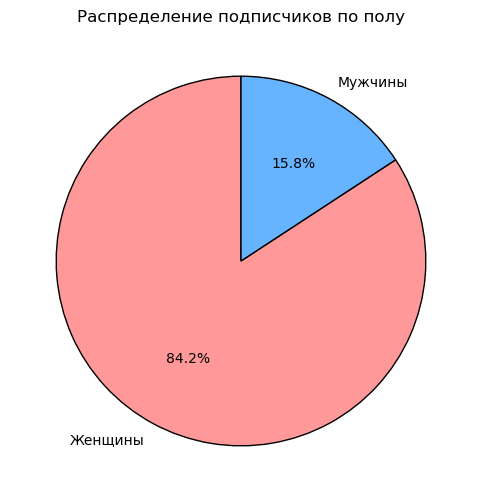

In [12]:
import matplotlib.pyplot as plt

# Проверяем распределение по полу
sex_counts = df['sex'].value_counts()

# Переименуем категории для наглядности
sex_labels = {1: 'Женщины', 2: 'Мужчины'}
sex_counts.index = sex_counts.index.map(sex_labels)

# Выводим количество
print("Распределение подписчиков по полу:")
print(sex_counts)

# Визуализация
plt.figure(figsize=(6, 6))
colors = ['#ff9999', '#66b3ff']  # Контрастные цвета
sex_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})
plt.title("Распределение подписчиков по полу")
plt.ylabel("")  # Убираем подпись оси
plt.show()


### Вывод

Большинство подписчиков – женщины (84%). Мужчин значительно меньше (16%), что подтверждает, что спрос со стороны мужчин минимален.


#### Задача 2.
Построить гистограмму с возрастом мужчин-подписчиков


In [15]:
# Проверим, какие столбцы есть в DataFrame
df_cleaned = pd.read_csv('vk_group_members_cleaned.csv')
print(df_cleaned.columns)


Index(['user_id', 'sex', 'bdate', 'city'], dtype='object')


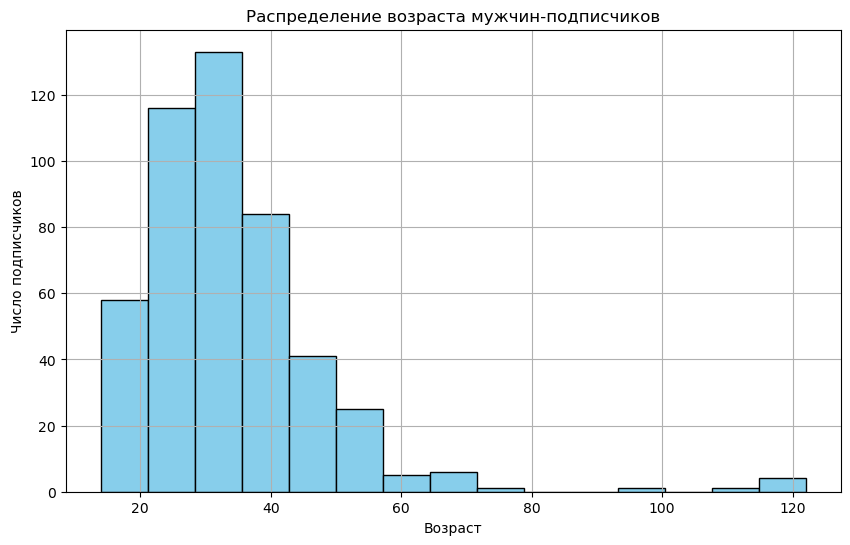

In [16]:
from datetime import datetime
import matplotlib.pyplot as plt

# Функция для вычисления возраста по дате рождения
def calculate_age(bdate):
    try:
        # Преобразуем строку даты в формат datetime
        birth_date = datetime.strptime(str(bdate), "%d.%m.%Y")
        today = datetime.today()
        # Вычисляем возраст
        return today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))
    except:
        # Если дата не распознана, возвращаем None
        return None

# Применяем функцию для вычисления возраста
df_cleaned['age'] = df_cleaned['bdate'].apply(calculate_age)

# Отфильтровываем только мужчин
df_men = df_cleaned[df_cleaned['sex'] == 2]

# Очищаем данные от некорректных значений (NaN) в возрасте
df_men = df_men[df_men['age'].notnull()]

# Строим гистограмму для возраста мужчин
plt.figure(figsize=(10, 6))
plt.hist(df_men['age'], bins=15, color='skyblue', edgecolor='black')
plt.title('Распределение возраста мужчин-подписчиков')
plt.xlabel('Возраст')
plt.ylabel('Число подписчиков')
plt.grid(True)
plt.show()


### Вывод

Подписанные мужчины в основном имеют возраст от 20 до 40 лет. Можно считать данный диапазон ядром мужской половины ЦА для таких услуг как мужской маникюр, например.

#### Задача 3.
Построить гистограмму с возрастами женщин-подписчиц


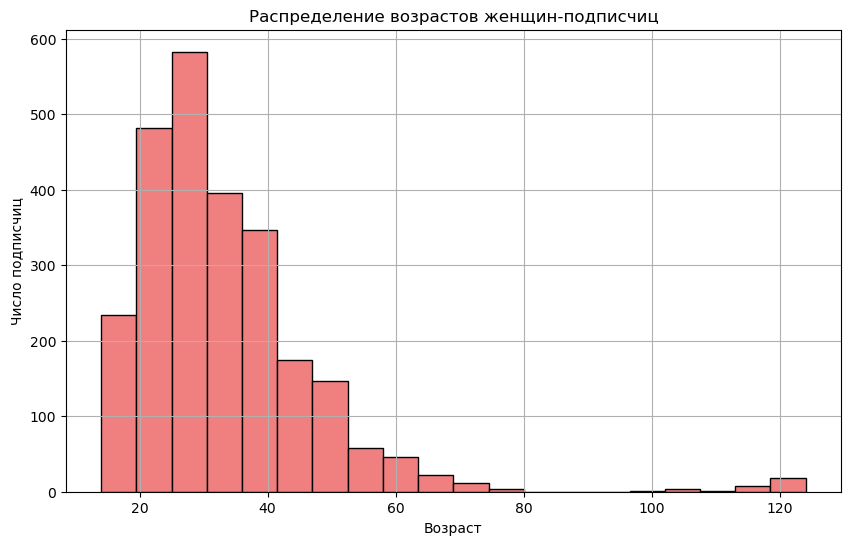

In [17]:
# Отфильтровываем только женщин
df_women = df_cleaned[df_cleaned['sex'] == 1]

# Очищаем данные от значений 'Неизвестно' и NaN
df_women = df_women[pd.to_numeric(df_women['age'], errors='coerce').notnull()]

# Преобразуем возраст в числовой формат
df_women['age'] = pd.to_numeric(df_women['age'])

# Строим гистограмму для возрастов женщин
plt.figure(figsize=(10, 6))
plt.hist(df_women['age'], bins=20, color='lightcoral', edgecolor='black')
plt.title('Распределение возрастов женщин-подписчиц')
plt.xlabel('Возраст')
plt.ylabel('Число подписчиц')
plt.grid(True)
plt.show()


### Вывод:

Из гистограммы распределения возрастов женщин-подписчиц можно сделать несколько выводов:

- Основная масса подписчиц сосредоточена в возрастной группе от 20 до 40 лет. Это подтверждает популярность маникюрных услуг среди молодых женщин.
- Мы можем заметить пик в возрасте около 25-30 лет, что указывает на высокую заинтересованность женщин в услугах маникюра в этот возрастной период.
- Число подписчиц значительно снижается после 40 лет, что может указывать на меньший интерес к услугам маникюра среди более старших возрастных групп.

Эти данные помогут в дальнейшем анализе целевой аудитории и могут быть полезны для корректировки маркетинговых стратегий, ориентированных на молодую аудиторию.


#### Задача 4:
Проанализировать подписчиков по городу (Москва/Не Москва).

Задача заключается в анализе данных о подписчиках для определения, кто из них указал город в своем профиле. Мы будем анализировать, сколько подписчиков из Москвы и других городов, а также оценим, насколько часто информация о городе доступна в профилях подписчиков.


In [21]:
# Задача 4: Проанализировать по городу (Москва/Не Москва)
# Создаем новый столбец для города, где указываем, является ли город Москвой

# Преобразуем столбец city в строку и заполняем пропуски значением 'Unknown'
df_cleaned['city'] = df_cleaned['city'].fillna('Unknown').astype(str)

# Создаем новый столбец для города, где указываем, является ли город Москвой
df_cleaned['is_moscow'] = df_cleaned['city'].apply(lambda x: 1 if x.lower() == 'москва' else 0)

# Вычисляем количество подписчиков с указанным городом
city_counts = df_cleaned['is_moscow'].value_counts()


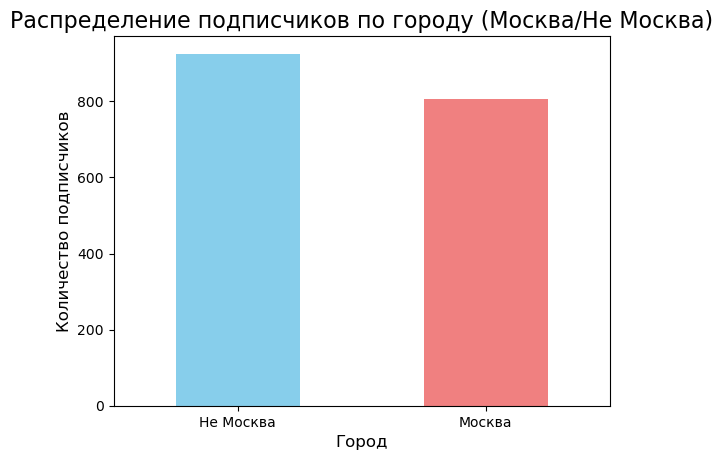

In [22]:
# Убираем записи с 'Unknown' в колонке 'city' для корректности анализа
df_cleaned = df_cleaned[df_cleaned['city'] != 'Unknown']

# Считаем количество подписчиков из Москвы и других городов
city_counts = df_cleaned['is_moscow'].value_counts()

# Построение графика распределения подписчиков по городу (Москва/Не Москва)
city_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])

# Настроим оформление графика
plt.title('Распределение подписчиков по городу (Москва/Не Москва)', fontsize=16)
plt.xlabel('Город', fontsize=12)
plt.ylabel('Количество подписчиков', fontsize=12)
plt.xticks([0, 1], ['Не Москва', 'Москва'], rotation=0)
plt.show()


### Вывод

Из анализа данных видно, что количество подписчиков, не проживающих в Москве, немного превышает количество подписчиков из самой Москвы. Это может свидетельствовать о том, что аудитория московских маникюрных салонов/мастеров не ограничивается исключительно москвичами. Такая ситуация может быть полезной для потенциальных рекламных стратегий, так как показывает, что интерес к этим сообществам существует и среди жителей других городов, что открывает возможности для расширения аудитории и продвижения услуг на более широкую географию.


### Задача 5: Фильтрация женщин среднего возраста из Москвы

**Цель задачи:**  
Отфильтровать женщин среднего возраста, проживающих в Москве, для последующего приглашения на интервью.

**Подход:**  
Для этой задачи нужно:
1. Отфильтровать женщин из Москвы.
2. Выбрать женщин среднего возраста по нашей выборке.
3. Сохранить этих пользователей для дальнейшего использования.


In [23]:
# Рассчитываем средний возраст женщин по выборке
mean_age_women = df_cleaned[df_cleaned['sex'] == 1]['age'].mean()

# Отфильтровываем женщин, проживающих в Москве
df_women_moscow = df_cleaned[(df_cleaned['sex'] == 1) & (df_cleaned['is_moscow'] == 1)]

# Фильтруем женщин с возрастом, близким к среднему (например, от -5 до +5 лет от среднего возраста)
df_near_mean_age_women = df_women_moscow[(df_women_moscow['age'] >= mean_age_women - 5) & 
                                          (df_women_moscow['age'] <= mean_age_women + 5)]

# Выводим отфильтрованных женщин
df_near_mean_age_women.head()


,user_id,sex,bdate,city,age,is_moscow
2,174259,1,16.4.1989,Москва,35,1
3,416658,1,30.5.1988,Москва,36,1
4,478629,1,14.8.1989,Москва,35,1
5,548787,1,9.1.1989,Москва,36,1
6,648060,1,4.11.1988,Москва,36,1


### Вывод

После фильтрации данных мы получили женщин, чей возраст близок к среднему возрасту по всей выборке, проживающих в Москве. Этот сегмент является интересным для дальнейшего анализа и проведения интервью, поскольку возраст, близкий к среднему, может отражать более общие тенденции в предпочтениях и потребностях в услугах маникюрных салонов.


### Итоги исследования: Демография подписчиков московских маникюрных салонов в ВК

**Цель исследования:**  
Проанализировать демографию подписчиков групп ВК московских маникюрных салонов и мастеров для оценки потенциального спроса и выбора целевой аудитории для рекламы.

**Задачи и результаты:**

1. **Анализ по полу:**  
   Женщины составляют 84% подписчиков, что подтверждает высокую заинтересованность женской аудитории в услугах маникюрных салонов.

2. **Анализ по возрасту мужчин:**  
   Мужчин среди подписчиков намного меньше (475), что говорит о низком уровне заинтересованности мужчин в услугах маникюра. Гистограмма показала, что мужчины, если они есть, в основном относятся к возрастным категориям до 35 лет.

3. **Анализ по возрасту женщин:**  
   Женщины, как основная аудитория, распределяются по различным возрастным группам. Это демонстрирует разнообразие возрастных предпочтений в салонах красоты и маникюра. Гистограмма показала, что большинство подписчиц моложе 40 лет.

4. **Анализ по географии (Москва/Не Москва):**  
   Большее количество подписчиков находится в Москве, однако и подписчики из других регионов тоже составляют значительную часть аудитории. Это может быть полезно для рекламных кампаний, направленных на привлечение пользователей из разных городов.

5. **Фильтрация женщин для интервью:**  
   Были отобраны женщины, для проведения с ними качественного интервью. С помощью датасетов получилось отобрать идеальных представителей целевой аудитории.
   
**Общий вывод:**  
Большинство подписчиков - женщины в возрасте до 35 лет, преимущественно из Москвы. Мужчины составляют лишь небольшую часть подписчиков, что подтверждает, что маникюрные салоны и услуги маникюра ориентированы в первую очередь на женскую аудиторию.
